In [177]:

import os
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from monai.transforms import (
    Compose, LoadImage, Resize, ScaleIntensity, ToTensor
)
from monai.networks.nets import UNet, AutoEncoder
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

from tqdm import tqdm


In [178]:
DATA_ROOT = "./data"
SLICE_RANGE = [145, 291]

CHANNELS = (16, 32, 64, 128, 256)
STRIDES = (2, 2, 2, 2, 2)

IMG_SIZE = (256,256)

NBR_EPOCH_ENCODEUR = 30
NBR_EPOCH_UNET = 50


## Selection des patients

In [179]:
all_patients = sorted(os.listdir(DATA_ROOT))
random.seed(42)
random.shuffle(all_patients)

test_patients = all_patients[:1]
unsupervised_patients = all_patients
supervised_patients = all_patients[9:]

print(f"Test: {test_patients}")
print(f"Unsupervised: {unsupervised_patients}")
print(f"Supervised: {supervised_patients}")


Test: ['07040DORE']
Unsupervised: ['07040DORE', '08031SEVE', '07010NABO', '07003SATH', '08037ROGU', '08029IVDI', '07001MOEL', '01039VITE', '07043SEME', '01040VANE', '01042GULE', '08027SYBR', '01016SACH', '01038PAGU', '08002CHJE']
Supervised: ['01040VANE', '01042GULE', '08027SYBR', '01016SACH', '01038PAGU', '08002CHJE']


## Proportion Masque vide par patient

In [180]:
def analyse_masques_vides_par_patient(dataset, indices=None):
    from collections import defaultdict

    vide_par_patient = defaultdict(lambda: {"total": 0, "vides": 0})

    if indices is None:
        indices = range(len(dataset))

    for idx in indices:
        if isinstance(dataset, torch.utils.data.Subset):
            vrai_idx = dataset.indices[idx]
            patient = dataset.dataset.get_patient_name(vrai_idx)
            _, mask, _ = dataset.dataset[vrai_idx]
        else:
            patient = dataset.get_patient_name(idx)
            _, mask, _ = dataset[idx]

        vide_par_patient[patient]["total"] += 1
        if mask.sum().item() == 0:
            vide_par_patient[patient]["vides"] += 1

    print(f"{'Patient':<15}{'Slices vides':<15}{'Total slices':<15}{'Proportion vide'}")
    print("-" * 60)
    for patient, stats in sorted(vide_par_patient.items()):
        total = stats["total"]
        vides = stats["vides"]
        proportion = vides / total if total > 0 else 0
        print(f"{patient:<15}{vides:<15}{total:<15}{proportion:.2%}")

## DataSet

In [181]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import re

class PngSlicesDataset(Dataset):
    """
    Dataset PyTorch pour charger des paires image/mask depuis des dossiers de slices PNG.
    G√®re les cas avec ou sans masque (pr√©-entra√Ænement ou entra√Ænement supervis√©).
    """
    def __init__(self, root_dir, with_mask=True, resized_size=IMG_SIZE, slice_range=None, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.patient_names = []
        self.resized_size = resized_size
        self.slice_range = slice_range
        self.with_mask = with_mask
        self.transform = transform if transform is not None else transforms.ToTensor()

        patients = sorted(os.listdir(root_dir))
        for patient in patients:
            images_folder = os.path.join(root_dir, patient, "IRM")
            masks_folder = os.path.join(root_dir, patient, "masque")

            if not os.path.isdir(images_folder):
                continue
            if self.with_mask and not os.path.isdir(masks_folder):
                continue

            for img_file in sorted(os.listdir(images_folder)):
                match = re.match(r"slice_(\d+)\.png", img_file)
                if not match:
                    continue

                slice_num = int(match.group(1))
                if self.slice_range and not (self.slice_range[0] <= slice_num <= self.slice_range[1]):
                    continue

                img_path = os.path.join(images_folder, img_file)
                if self.with_mask:
                    mask_path = os.path.join(masks_folder, img_file)
                    if not os.path.exists(mask_path):
                        continue
                    self.mask_paths.append(mask_path)

                self.image_paths.append(img_path)
                self.patient_names.append(patient)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')
        resize = transforms.Resize(self.resized_size)
        img = resize(img)
        img = self.transform(img)
        img = (img - 0.5) / 0.5  # Normalisation [-1, 1]

        if self.with_mask:
            mask = Image.open(self.mask_paths[idx]).convert('L')
            mask = resize(mask)
            mask = self.transform(mask)
            mask = (mask > 0.5).float()
            return img, mask, self.image_paths[idx]
        else:
            return img, self.image_paths[idx]

    def get_patient_name(self, idx):
        return self.patient_names[idx]


## DataLoader

In [182]:
# Cr√©ation des datasets
unsup_dataset = PngSlicesDataset(root_dir=DATA_ROOT, with_mask=False, resized_size=IMG_SIZE, slice_range=SLICE_RANGE)
sup_dataset = PngSlicesDataset(root_dir=DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE)
test_dataset = PngSlicesDataset(root_dir=DATA_ROOT, with_mask=True, resized_size=IMG_SIZE, slice_range=SLICE_RANGE)

analyse_masques_vides_par_patient(sup_dataset)

# DataLoaders
unsup_loader = DataLoader(unsup_dataset, batch_size=16, shuffle=True)
sup_loader = DataLoader(sup_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Patient        Slices vides   Total slices   Proportion vide
------------------------------------------------------------
01016SACH      4              134            2.99%
01038PAGU      9              138            6.52%
01039VITE      6              130            4.62%
01040VANE      29             66             43.94%
01042GULE      12             105            11.43%
07001MOEL      16             99             16.16%
07003SATH      6              134            4.48%
07010NABO      21             88             23.86%
07040DORE      14             103            13.59%
07043SEME      17             108            15.74%
08002CHJE      8              126            6.35%
08027SYBR      18             97             18.56%
08029IVDI      11             127            8.66%
08031SEVE      19             120            15.83%
08037ROGU      1              145            0.69%


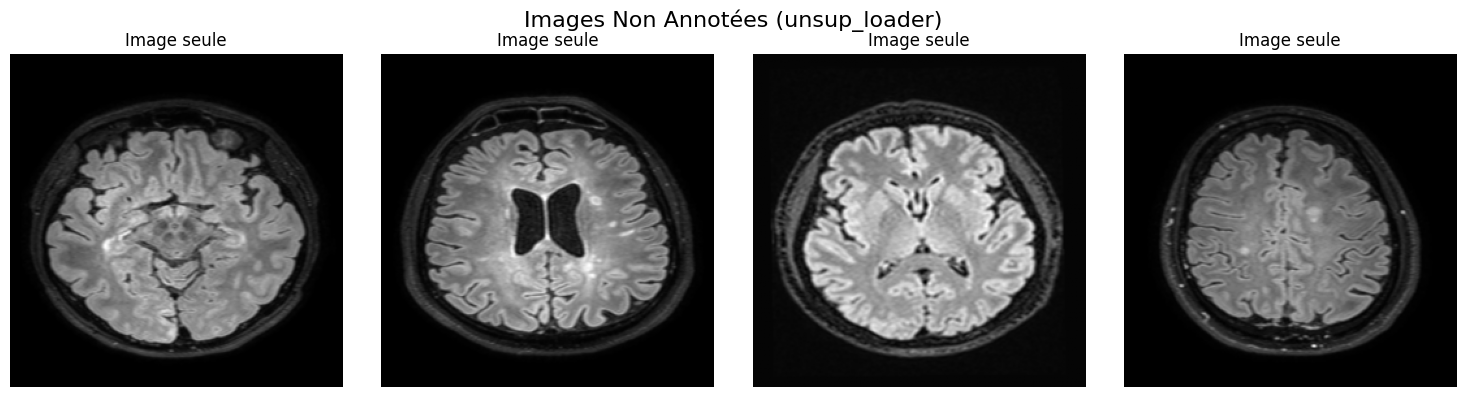

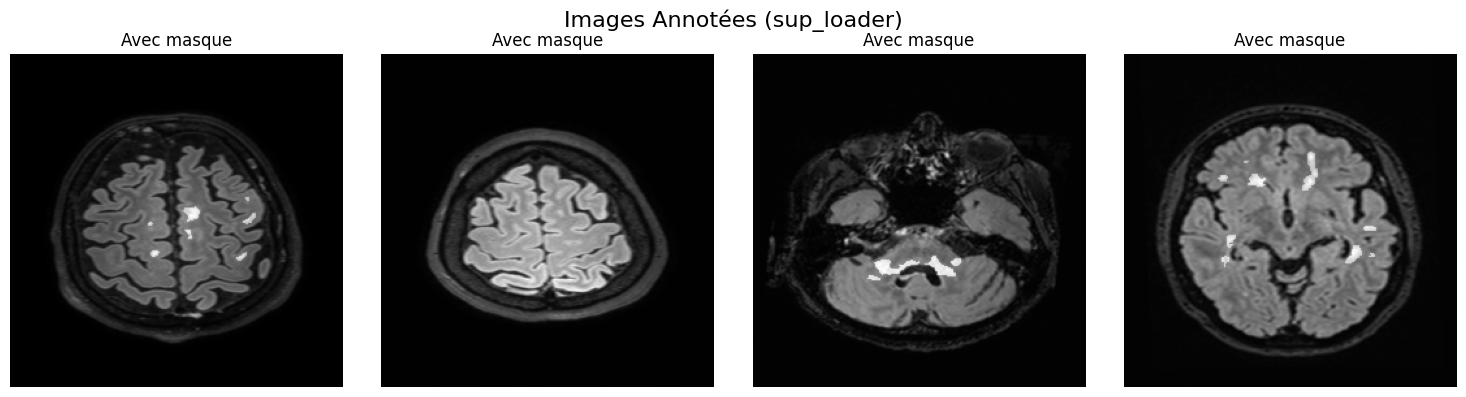

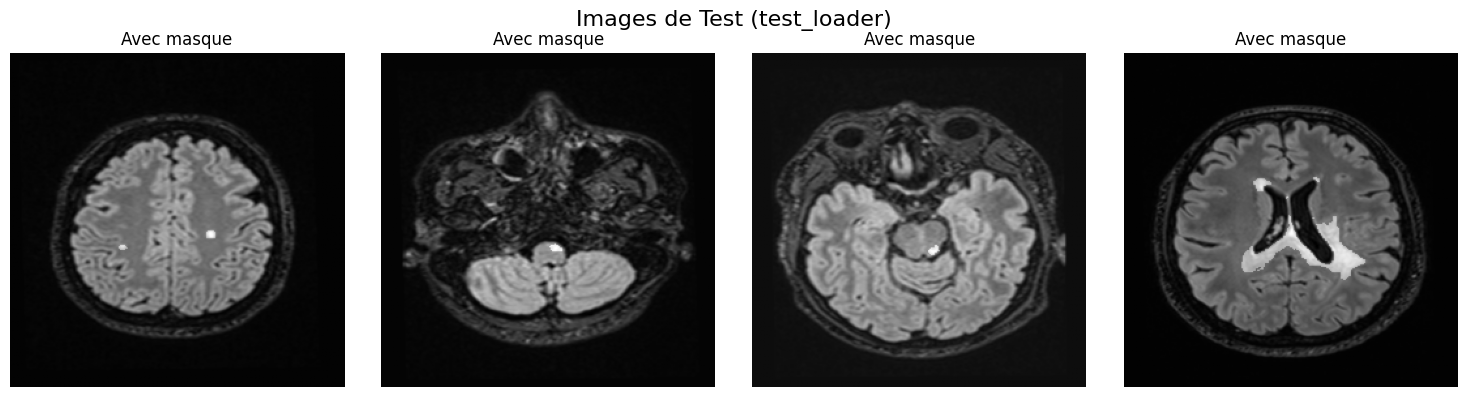

In [183]:
import matplotlib.pyplot as plt

def afficher_batch(loader, titre, with_mask):
    imgs, *rest = next(iter(loader))
    imgs = imgs[:4].cpu()  # Afficher seulement 4 images

    if with_mask:
        masks = rest[0][:4].cpu()
    else:
        masks = [None] * len(imgs)

    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 4))
    fig.suptitle(titre, fontsize=16)

    for i, (img, mask) in enumerate(zip(imgs, masks)):
        img_np = img.squeeze().numpy()

        if mask is not None:
            mask_np = mask.squeeze().numpy()
            combined = img_np * 0.6 + mask_np * 0.4
            axes[i].imshow(combined, cmap='gray')
            axes[i].set_title("Avec masque")
        else:
            axes[i].imshow(img_np, cmap='gray')
            axes[i].set_title("Image seule")

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Affichages
afficher_batch(unsup_loader, "Images Non Annot√©es (unsup_loader)", with_mask=False)
afficher_batch(sup_loader, "Images Annot√©es (sup_loader)", with_mask=True)
afficher_batch(test_loader, "Images de Test (test_loader)", with_mask=True)


## Auto Encodeur MONAI

In [184]:
from monai.networks.nets import AutoEncoder

autoencoder = AutoEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=CHANNELS,
    strides=STRIDES
).cuda()

autoenc_loss = torch.nn.MSELoss()
autoenc_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)


## Entrainement Auto Encodeur MONAI

In [185]:
best_loss = float('inf')  # perte minimale observ√©e
best_model_path = "best_autoencoder.pth"

for epoch in range(NBR_EPOCH_ENCODEUR):
    autoencoder.train()
    total_loss = 0.0

    print(f"\n[AutoEncoder] Epoch {epoch+1}")
    for imgs, paths in tqdm(unsup_loader, desc="Batch", leave=False):
        imgs = imgs.cuda()

        recon = autoencoder(imgs)
        loss = autoenc_loss(recon, imgs)

        autoenc_optimizer.zero_grad()
        loss.backward()
        autoenc_optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(unsup_loader)
    print(f"[‚úì] Epoch {epoch+1} termin√© - Perte moyenne : {epoch_loss:.4f}")

    # üî• Sauvegarde si c'est la meilleure perte
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(autoencoder.state_dict(), best_model_path)
        print(f"üíæ Meilleur mod√®le sauvegard√© (loss = {best_loss:.4f})")



[AutoEncoder] Epoch 1


[‚úì] Epoch 1 termin√© - Perte moyenne : 0.1260
üíæ Meilleur mod√®le sauvegard√© (loss = 0.1260)

[AutoEncoder] Epoch 2


[‚úì] Epoch 2 termin√© - Perte moyenne : 0.0383
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0383)

[AutoEncoder] Epoch 3


[‚úì] Epoch 3 termin√© - Perte moyenne : 0.0293
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0293)

[AutoEncoder] Epoch 4


[‚úì] Epoch 4 termin√© - Perte moyenne : 0.0247
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0247)

[AutoEncoder] Epoch 5


[‚úì] Epoch 5 termin√© - Perte moyenne : 0.0206
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0206)

[AutoEncoder] Epoch 6


[‚úì] Epoch 6 termin√© - Perte moyenne : 0.0167
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0167)

[AutoEncoder] Epoch 7


[‚úì] Epoch 7 termin√© - Perte moyenne : 0.0130
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0130)

[AutoEncoder] Epoch 8


[‚úì] Epoch 8 termin√© - Perte moyenne : 0.0105
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0105)

[AutoEncoder] Epoch 9


[‚úì] Epoch 9 termin√© - Perte moyenne : 0.0093
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0093)

[AutoEncoder] Epoch 10


[‚úì] Epoch 10 termin√© - Perte moyenne : 0.0084
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0084)

[AutoEncoder] Epoch 11


[‚úì] Epoch 11 termin√© - Perte moyenne : 0.0078
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0078)

[AutoEncoder] Epoch 12


[‚úì] Epoch 12 termin√© - Perte moyenne : 0.0071
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0071)

[AutoEncoder] Epoch 13


[‚úì] Epoch 13 termin√© - Perte moyenne : 0.0067
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0067)

[AutoEncoder] Epoch 14


[‚úì] Epoch 14 termin√© - Perte moyenne : 0.0063
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0063)

[AutoEncoder] Epoch 15


[‚úì] Epoch 15 termin√© - Perte moyenne : 0.0059
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0059)

[AutoEncoder] Epoch 16


[‚úì] Epoch 16 termin√© - Perte moyenne : 0.0057
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0057)

[AutoEncoder] Epoch 17


[‚úì] Epoch 17 termin√© - Perte moyenne : 0.0055
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0055)

[AutoEncoder] Epoch 18


[‚úì] Epoch 18 termin√© - Perte moyenne : 0.0051
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0051)

[AutoEncoder] Epoch 19


[‚úì] Epoch 19 termin√© - Perte moyenne : 0.0049
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0049)

[AutoEncoder] Epoch 20


[‚úì] Epoch 20 termin√© - Perte moyenne : 0.0047
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0047)

[AutoEncoder] Epoch 21


[‚úì] Epoch 21 termin√© - Perte moyenne : 0.0047
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0047)

[AutoEncoder] Epoch 22


[‚úì] Epoch 22 termin√© - Perte moyenne : 0.0044
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0044)

[AutoEncoder] Epoch 23


[‚úì] Epoch 23 termin√© - Perte moyenne : 0.0042
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0042)

[AutoEncoder] Epoch 24


[‚úì] Epoch 24 termin√© - Perte moyenne : 0.0041
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0041)

[AutoEncoder] Epoch 25


[‚úì] Epoch 25 termin√© - Perte moyenne : 0.0041

[AutoEncoder] Epoch 26


[‚úì] Epoch 26 termin√© - Perte moyenne : 0.0038
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0038)

[AutoEncoder] Epoch 27


[‚úì] Epoch 27 termin√© - Perte moyenne : 0.0038

[AutoEncoder] Epoch 28


[‚úì] Epoch 28 termin√© - Perte moyenne : 0.0037
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0037)

[AutoEncoder] Epoch 29


[‚úì] Epoch 29 termin√© - Perte moyenne : 0.0037
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0037)

[AutoEncoder] Epoch 30


[‚úì] Epoch 30 termin√© - Perte moyenne : 0.0035
üíæ Meilleur mod√®le sauvegard√© (loss = 0.0035)


## UNet

In [186]:
from monai.networks.nets import UNet

unet = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=CHANNELS,
    strides=STRIDES,
    num_res_units=1
).cuda()    

# Impression de la structure (utile pour confirmer les correspondances)
print("üß† Structure AutoEncoder :")
print(autoencoder.encode)

print("\nüß† Structure UNet (encodage) :")
print(unet.model[:2])  # On regarde les 2 premiers blocs de l'encodeur

with torch.no_grad():
    ae_enc = autoencoder.encode

    # Niveau 0 : 1 ‚Üí 16
    unet.model[0].conv.unit0.conv.weight.copy_(ae_enc.encode_0.conv.weight)
    unet.model[0].conv.unit0.conv.bias.copy_(ae_enc.encode_0.conv.bias)

    # Niveau 1 : 16 ‚Üí 32
    unet.model[1].submodule[0].conv.unit0.conv.weight.copy_(ae_enc.encode_1.conv.weight)
    unet.model[1].submodule[0].conv.unit0.conv.bias.copy_(ae_enc.encode_1.conv.bias)

    # Niveau 2 : 32 ‚Üí 64
    unet.model[1].submodule[1].submodule[0].conv.unit0.conv.weight.copy_(ae_enc.encode_2.conv.weight)
    unet.model[1].submodule[1].submodule[0].conv.unit0.conv.bias.copy_(ae_enc.encode_2.conv.bias)

    # Niveau 3 : 64 ‚Üí 128
    unet.model[1].submodule[1].submodule[1].submodule[0].conv.unit0.conv.weight.copy_(ae_enc.encode_3.conv.weight)
    unet.model[1].submodule[1].submodule[1].submodule[0].conv.unit0.conv.bias.copy_(ae_enc.encode_3.conv.bias)

    # Niveau 4 : 128 ‚Üí 256
    unet.model[1].submodule[1].submodule[1].submodule[1].submodule.conv.unit0.conv.weight.copy_(ae_enc.encode_4.conv.weight)
    unet.model[1].submodule[1].submodule[1].submodule[1].submodule.conv.unit0.conv.bias.copy_(ae_enc.encode_4.conv.bias)

print("‚úÖ Transfert manuel des poids Conv2d termin√©.")




`len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.


üß† Structure AutoEncoder :
Sequential(
  (encode_0): Convolution(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (encode_1): Convolution(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (encode_2): Convolution(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (A): PReLU(num_parameters=1)
    )
  )
  (encode_3): Convolution(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(128, eps=1e-05, momentum=0

## ComboLoss

In [187]:
# ComboLoss : combinaison Dice + BCE pond√©r√©
class ComboLoss(nn.Module):
    def __init__(self, dice_weight=0.7, pos_weight=20.0):
        super().__init__()
        self.dice = DiceLoss(sigmoid=True)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).cuda())
        self.dice_weight = dice_weight

    def forward(self, inputs, targets):
        dice_loss = self.dice(inputs, targets)
        bce_loss = self.bce(inputs, targets)
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss


## Fine-tunning

In [188]:
import torch

# Initialisation
criterion = ComboLoss(dice_weight=0.7)
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

best_loss = float('inf')
best_model_path = "best_unet.pth"

# Boucle d'entra√Ænement
for epoch in range(NBR_EPOCH_UNET):
    unet.train()
    total_loss = 0.0

    print(f"\n[Fine-tuning] Epoch {epoch+1}")
    for imgs, masks, _ in tqdm(sup_loader, desc="Batchs"):
        imgs, masks = imgs.cuda(), masks.cuda()

        preds = unet(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(sup_loader)
    print(f"[‚úì] Epoch {epoch+1} - Perte moyenne : {epoch_loss:.4f}")

    # üî• Sauvegarde si c'est la meilleure
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(unet.state_dict(), best_model_path)
        print(f"üíæ Meilleur mod√®le sauvegard√© (loss = {best_loss:.4f})")



[Fine-tuning] Epoch 1


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:51<00:00,  4.21it/s]


[‚úì] Epoch 1 - Perte moyenne : 0.9337
üíæ Meilleur mod√®le sauvegard√© (loss = 0.9337)

[Fine-tuning] Epoch 2


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:50<00:00,  4.27it/s]


[‚úì] Epoch 2 - Perte moyenne : 0.9130
üíæ Meilleur mod√®le sauvegard√© (loss = 0.9130)

[Fine-tuning] Epoch 3


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:48<00:00,  4.45it/s]


[‚úì] Epoch 3 - Perte moyenne : 0.9040
üíæ Meilleur mod√®le sauvegard√© (loss = 0.9040)

[Fine-tuning] Epoch 4


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:50<00:00,  4.24it/s]


[‚úì] Epoch 4 - Perte moyenne : 0.8976
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8976)

[Fine-tuning] Epoch 5


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:52<00:00,  4.06it/s]


[‚úì] Epoch 5 - Perte moyenne : 0.8925
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8925)

[Fine-tuning] Epoch 6


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:47<00:00,  4.53it/s]


[‚úì] Epoch 6 - Perte moyenne : 0.8878
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8878)

[Fine-tuning] Epoch 7


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:46<00:00,  4.61it/s]


[‚úì] Epoch 7 - Perte moyenne : 0.8836
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8836)

[Fine-tuning] Epoch 8


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:43<00:00,  4.97it/s]


[‚úì] Epoch 8 - Perte moyenne : 0.8796
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8796)

[Fine-tuning] Epoch 9


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:39<00:00,  5.40it/s]


[‚úì] Epoch 9 - Perte moyenne : 0.8757
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8757)

[Fine-tuning] Epoch 10


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.80it/s]


[‚úì] Epoch 10 - Perte moyenne : 0.8721
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8721)

[Fine-tuning] Epoch 11


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:48<00:00,  4.40it/s]


[‚úì] Epoch 11 - Perte moyenne : 0.8685
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8685)

[Fine-tuning] Epoch 12


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:45<00:00,  4.73it/s]


[‚úì] Epoch 12 - Perte moyenne : 0.8650
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8650)

[Fine-tuning] Epoch 13


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.85it/s]


[‚úì] Epoch 13 - Perte moyenne : 0.8615
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8615)

[Fine-tuning] Epoch 14


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:51<00:00,  4.17it/s]


[‚úì] Epoch 14 - Perte moyenne : 0.8581
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8581)

[Fine-tuning] Epoch 15


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:53<00:00,  4.04it/s]


[‚úì] Epoch 15 - Perte moyenne : 0.8547
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8547)

[Fine-tuning] Epoch 16


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:47<00:00,  4.49it/s]


[‚úì] Epoch 16 - Perte moyenne : 0.8513
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8513)

[Fine-tuning] Epoch 17


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.84it/s]


[‚úì] Epoch 17 - Perte moyenne : 0.8479
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8479)

[Fine-tuning] Epoch 18


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:46<00:00,  4.66it/s]


[‚úì] Epoch 18 - Perte moyenne : 0.8446
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8446)

[Fine-tuning] Epoch 19


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:47<00:00,  4.48it/s]


[‚úì] Epoch 19 - Perte moyenne : 0.8412
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8412)

[Fine-tuning] Epoch 20


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:43<00:00,  4.97it/s]


[‚úì] Epoch 20 - Perte moyenne : 0.8378
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8378)

[Fine-tuning] Epoch 21


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:41<00:00,  5.22it/s]


[‚úì] Epoch 21 - Perte moyenne : 0.8344
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8344)

[Fine-tuning] Epoch 22


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:41<00:00,  5.24it/s]


[‚úì] Epoch 22 - Perte moyenne : 0.8309
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8309)

[Fine-tuning] Epoch 23


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:42<00:00,  5.02it/s]


[‚úì] Epoch 23 - Perte moyenne : 0.8273
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8273)

[Fine-tuning] Epoch 24


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.84it/s]


[‚úì] Epoch 24 - Perte moyenne : 0.8236
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8236)

[Fine-tuning] Epoch 25


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:52<00:00,  4.07it/s]


[‚úì] Epoch 25 - Perte moyenne : 0.8198
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8198)

[Fine-tuning] Epoch 26


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.84it/s]


[‚úì] Epoch 26 - Perte moyenne : 0.8159
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8159)

[Fine-tuning] Epoch 27


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:43<00:00,  4.89it/s]


[‚úì] Epoch 27 - Perte moyenne : 0.8120
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8120)

[Fine-tuning] Epoch 28


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.82it/s]


[‚úì] Epoch 28 - Perte moyenne : 0.8080
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8080)

[Fine-tuning] Epoch 29


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:34<00:00,  6.29it/s]


[‚úì] Epoch 29 - Perte moyenne : 0.8041
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8041)

[Fine-tuning] Epoch 30


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:34<00:00,  6.16it/s]


[‚úì] Epoch 30 - Perte moyenne : 0.8000
üíæ Meilleur mod√®le sauvegard√© (loss = 0.8000)

[Fine-tuning] Epoch 31


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:45<00:00,  4.77it/s]


[‚úì] Epoch 31 - Perte moyenne : 0.7960
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7960)

[Fine-tuning] Epoch 32


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:44<00:00,  4.78it/s]


[‚úì] Epoch 32 - Perte moyenne : 0.7918
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7918)

[Fine-tuning] Epoch 33


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:38<00:00,  5.60it/s]


[‚úì] Epoch 33 - Perte moyenne : 0.7874
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7874)

[Fine-tuning] Epoch 34


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:38<00:00,  5.64it/s]


[‚úì] Epoch 34 - Perte moyenne : 0.7822
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7822)

[Fine-tuning] Epoch 35


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:37<00:00,  5.81it/s]


[‚úì] Epoch 35 - Perte moyenne : 0.7748
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7748)

[Fine-tuning] Epoch 36


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:38<00:00,  5.56it/s]


[‚úì] Epoch 36 - Perte moyenne : 0.7644
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7644)

[Fine-tuning] Epoch 37


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:33<00:00,  6.39it/s]


[‚úì] Epoch 37 - Perte moyenne : 0.7540
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7540)

[Fine-tuning] Epoch 38


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:33<00:00,  6.51it/s]


[‚úì] Epoch 38 - Perte moyenne : 0.7446
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7446)

[Fine-tuning] Epoch 39


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:39<00:00,  5.46it/s]


[‚úì] Epoch 39 - Perte moyenne : 0.7356
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7356)

[Fine-tuning] Epoch 40


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:38<00:00,  5.62it/s]


[‚úì] Epoch 40 - Perte moyenne : 0.7271
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7271)

[Fine-tuning] Epoch 41


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:39<00:00,  5.44it/s]


[‚úì] Epoch 41 - Perte moyenne : 0.7188
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7188)

[Fine-tuning] Epoch 42


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:39<00:00,  5.50it/s]


[‚úì] Epoch 42 - Perte moyenne : 0.7109
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7109)

[Fine-tuning] Epoch 43


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:35<00:00,  6.10it/s]


[‚úì] Epoch 43 - Perte moyenne : 0.7029
üíæ Meilleur mod√®le sauvegard√© (loss = 0.7029)

[Fine-tuning] Epoch 44


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:33<00:00,  6.49it/s]


[‚úì] Epoch 44 - Perte moyenne : 0.6949
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6949)

[Fine-tuning] Epoch 45


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:36<00:00,  5.97it/s]


[‚úì] Epoch 45 - Perte moyenne : 0.6870
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6870)

[Fine-tuning] Epoch 46


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:41<00:00,  5.21it/s]


[‚úì] Epoch 46 - Perte moyenne : 0.6791
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6791)

[Fine-tuning] Epoch 47


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:36<00:00,  5.93it/s]


[‚úì] Epoch 47 - Perte moyenne : 0.6711
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6711)

[Fine-tuning] Epoch 48


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:33<00:00,  6.35it/s]


[‚úì] Epoch 48 - Perte moyenne : 0.6630
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6630)

[Fine-tuning] Epoch 49


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:32<00:00,  6.56it/s]


[‚úì] Epoch 49 - Perte moyenne : 0.6547
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6547)

[Fine-tuning] Epoch 50


Batchs: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:33<00:00,  6.50it/s]

[‚úì] Epoch 50 - Perte moyenne : 0.6460
üíæ Meilleur mod√®le sauvegard√© (loss = 0.6460)


## Evaluate with test dataset

√âvaluation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 215/215 [00:34<00:00,  6.20it/s]



üéØ Dice moyen sur le test set : 0.5501 (sur 1529 slices valides)


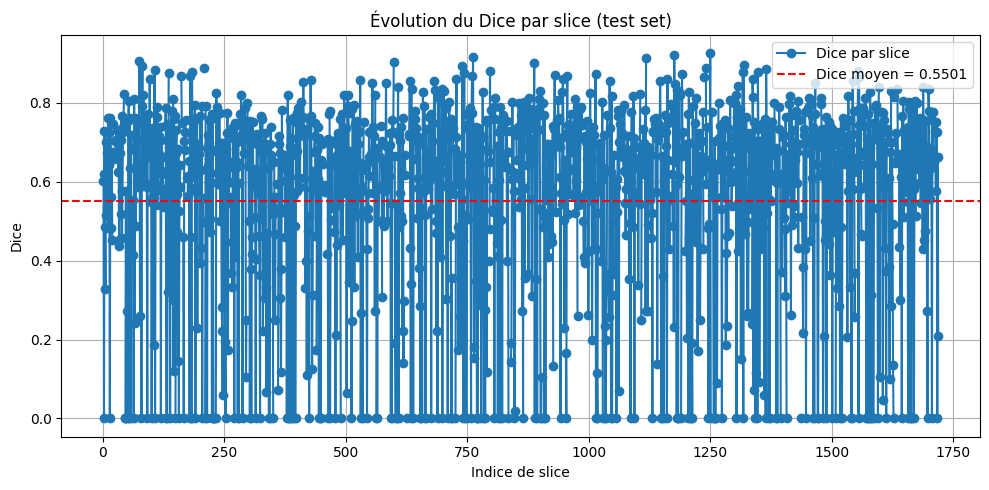

In [189]:
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt
import numpy as np
import torch

# Initialisation du DiceMetric MONAI
dice_metric = DiceMetric(include_background=False, reduction="none")
dice_per_slice = []

unet.eval()
with torch.no_grad():
    for imgs, masks, _ in tqdm(test_loader, desc="√âvaluation"):
        imgs, masks = imgs.cuda(), masks.cuda()

        # ‚úÖ Application du Sigmoid sur la sortie brute
        outputs = torch.sigmoid(unet(imgs))

        # Calcul du Dice par slice
        batch_dice = dice_metric(y_pred=outputs, y=masks)  # shape: (batch_size,)
        dice_values = batch_dice.cpu().numpy().flatten().tolist()
        dice_per_slice.extend(dice_values)

# Nettoyage : exclusion des NaN (slices avec masque vide ou sortie plate)
dice_clean = [d for d in dice_per_slice if not np.isnan(d)]
mean_dice = np.mean(dice_clean) if dice_clean else 0.0

# ‚úÖ R√©sum√© global
print(f"\nüéØ Dice moyen sur le test set : {mean_dice:.4f} (sur {len(dice_clean)} slices valides)")

# üîç Trac√© de l‚Äô√©volution
plt.figure(figsize=(10, 5))
plt.plot(dice_per_slice, label="Dice par slice", marker='o')
plt.axhline(mean_dice, color='r', linestyle='--', label=f"Dice moyen = {mean_dice:.4f}")
plt.xlabel("Indice de slice")
plt.ylabel("Dice")
plt.title("√âvolution du Dice par slice (test set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Reset du DiceMetric
dice_metric.reset()


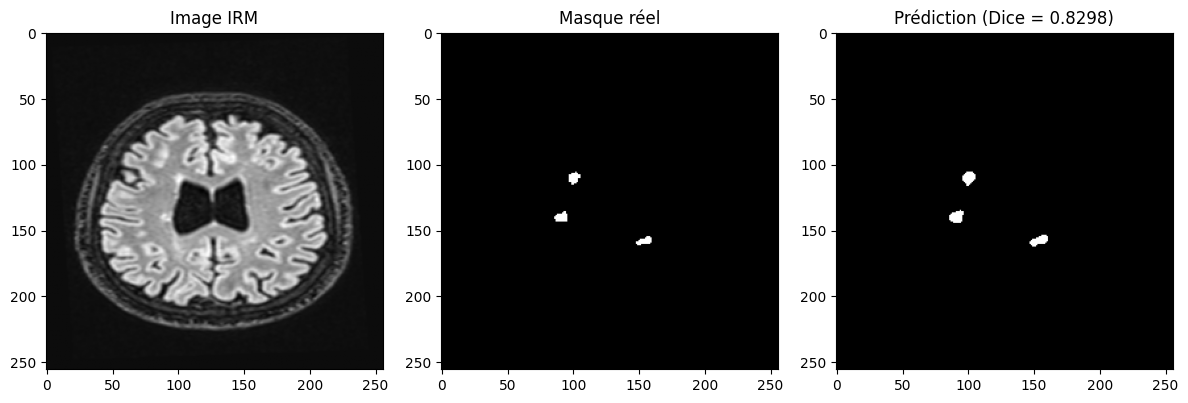

In [203]:
# Visualisation d'une image avec son score
imgs, masks, paths = next(iter(test_loader))
imgs, masks = imgs.cuda(), masks.cuda()
with torch.no_grad():
    outputs = unet(imgs)
    outputs_sigmoid = torch.sigmoid(outputs)
    preds = (outputs_sigmoid > 0.5).float()

    # Dice local (sur cette image uniquement)
    dice_local = DiceMetric(include_background=False, reduction="mean")
    dice_local(preds, masks)
    score_slice = dice_local.aggregate().item()

# Visualisation
img_np = imgs[0].cpu().squeeze().numpy()
mask_np = masks[0].cpu().squeeze().numpy()
pred_np = preds[0].cpu().squeeze().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np, cmap="gray")
plt.title("Image IRM")

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap="gray")
plt.title("Masque r√©el")

plt.subplot(1, 3, 3)
plt.imshow(pred_np, cmap="gray")
plt.title(f"Pr√©diction (Dice = {score_slice:.4f})")

plt.tight_layout()
plt.show()